In [287]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.offline as py
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import json


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score,balanced_accuracy_score
from sklearn.utils import shuffle

from plotly import express as px
from plotnine import ggplot, aes, geom_jitter, scale_colour_brewer, theme_minimal, labs, theme

from utils.utils import plot_confusion_matrix

import os

import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

from joblib import load, dump
%matplotlib inline
pd.set_option('display.max_columns', 30)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

In [288]:
# Paths
BASE_DIR = './'
PETFINDER_PATH = "../petfinder-adoption-prediction/"
PATH_TO_TRAIN = os.path.join(BASE_DIR, "train/df_checkpoint_2.csv") # este dataframe es train.csv + las features de las descripciones de DescriptionFeaturesPipeline.ipynb
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")

PATH_TO_COLORS = os.path.join(PETFINDER_PATH, "ColorLabels.csv")
PATH_TO_BREEDS = os.path.join(PETFINDER_PATH, "BreedLabels.csv")
PATH_TO_STATES = os.path.join(PETFINDER_PATH, "StateLabels.csv")
PATH_TO_TEST = os.path.join(BASE_DIR, "test/test_df_checkpoint_2.csv") # este dataframe es test.csv + las features de las descripciones de DescriptionFeaturesPipeline.ipynb

PATH_TO_SENTIMENT_TRAIN = os.path.join(PETFINDER_PATH, "train_sentiment/")
PATH_TO_SENTIMENT_TEST = os.path.join(PETFINDER_PATH, "test_sentiment/")

PATH_PET_IMAGE_QUALITY_TRAIN = os.path.join(BASE_DIR, "train/pet_images_quality.csv")
PATH_PET_IMAGE_QUALITY_TEST = os.path.join("./", "test/pet_images_quality_test.csv")

CLIP_FEATURES_TRAIN = os.path.join(BASE_DIR, "train/clip_features.json")
CLIP_FEATURES_TEST = os.path.join(BASE_DIR, "test/clip_features_test.json")

PATH_TO_METADATA_TRAIN = os.path.join(PETFINDER_PATH, "train_metadata/")
PATH_TO_METADATA_TEST = os.path.join(PETFINDER_PATH, "test_metadata/")

SEED = 42
BATCH_SIZE = 50
TEST_SIZE = 0.2

# Datos Tabulares
dataset = pd.read_csv(PATH_TO_TRAIN)
test_dataset = pd.read_csv(PATH_TO_TEST)

colors = pd.read_csv(PATH_TO_COLORS)
breeds = pd.read_csv(PATH_TO_BREEDS)
states = pd.read_csv(PATH_TO_STATES)

In [289]:
dataset.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Language', 'Translated_Description',
       'Is the pet described as friendly?',
       'Does the pet require special care?',
       'Is the pet currently with the owner?',
       'Is the pet good with other animals?', 'Is the pet's adoption urgent?',
       'Does the pet need a lot of space?',
       'Is the pet described as lovely or loveable?',
       'Is there a contact person mentioned?',
       'Must these pets be adopted as a group?',
       'Does the pet need medical care?', 'must always be kept indoors'],
      dtype='object')

In [290]:
# Limpar PetsIDs duplicados
dataset = dataset.drop_duplicates(subset=["PetID"], keep="first")
test_dataset = test_dataset.drop_duplicates(subset=["PetID"], keep="first")


In [291]:
dataset.shape, test_dataset.shape

((14993, 37), (3972, 36))

Text(0.5, 1.0, 'Adoption speed classes counts')

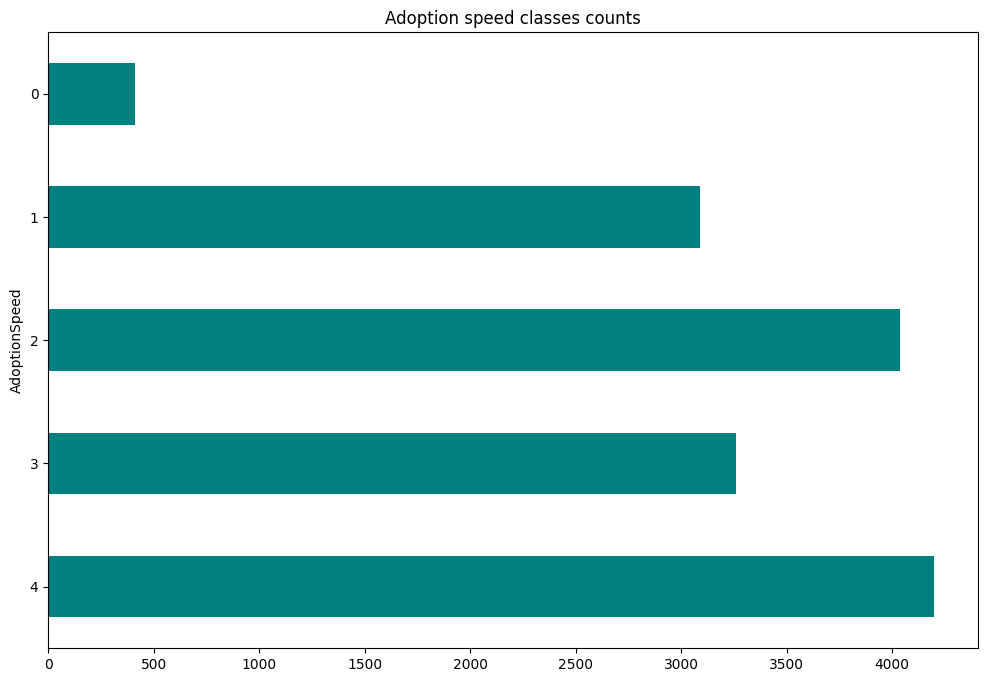

In [292]:
dataset['AdoptionSpeed'].value_counts().sort_index(ascending = False).plot(kind='barh', color='teal');
plt.title('Adoption speed classes counts')

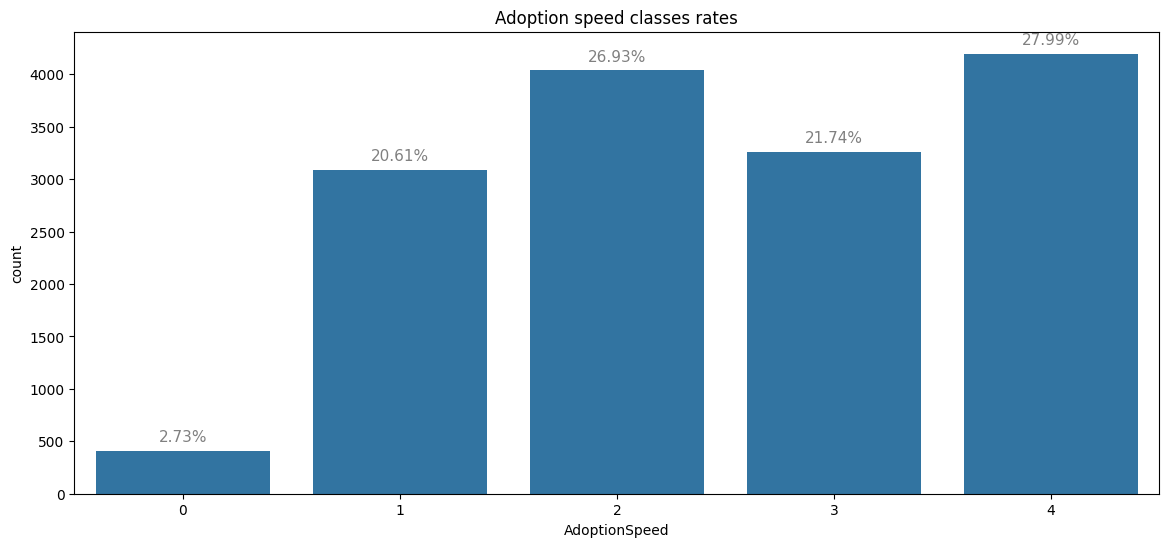

In [293]:
#Vemos adoption speed en proporciones: 
plt.figure(figsize=(14, 6))
g = sns.countplot(x='AdoptionSpeed', data=dataset)
plt.title('Adoption speed classes rates')
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dataset.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')  

Notamos que: 

-Algunas mascotas son adoptadas inmediatamente, pero es un pequeño porcentaje. (2%)

-En general las mascotas tienen que esperar para ser adoptadas; Hay un 28% que debe esperar por lo menos 4 meses.

<Axes: xlabel='Type'>

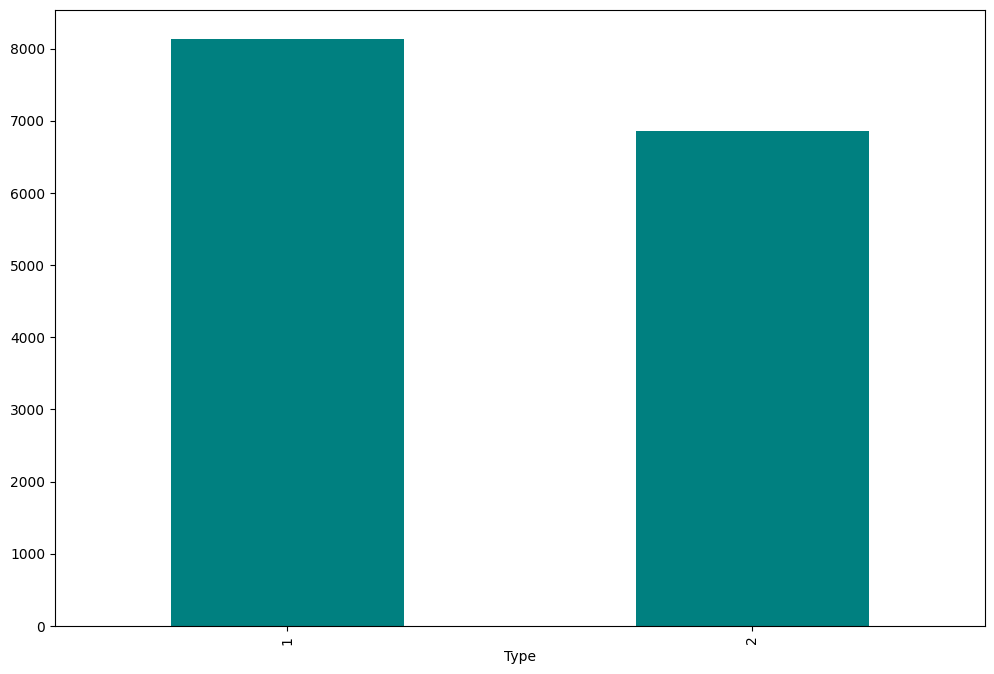

In [294]:
#GRAFICO PERROS Y GATOS:
dataset['Type'].value_counts().plot(kind='bar', color='teal')

In [295]:
#CALCULO TASAS DE ADOPTION: ESTAS SON LAS TASAS DE ADOPCION GENERALES POR VELOCIDAD DE ADOPTION SIN DISTINCION ALGUNA. 
main_count = dataset['AdoptionSpeed'].value_counts(normalize=True).sort_index()
print(main_count)

AdoptionSpeed
0    0.027346
1    0.206096
2    0.269259
3    0.217368
4    0.279931
Name: proportion, dtype: float64


In [296]:
diccionario_maincount = dict(main_count)
print(diccionario_maincount)

{0: 0.027346094844260656, 1: 0.20609617821650103, 2: 0.2692589875275128, 3: 0.21736810511572066, 4: 0.2799306342960048}


In [297]:
#FUNCION QUE CALCULA TASA DE ADOPTION ESPECIFICA VS TASA DE ADOPTION GENERAL.  %Adoptado gato clase 0 / %clase 0
def prepare_plot_dict(df, col, diccionario_maincount):
    
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in diccionario_maincount.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / diccionario_maincount[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

In [298]:
#FUNCION QUE GRAFICA EL COUNT PLOT DE ADOPTION SPEED CON LOS PORCENTAJES DE DIFERENCIA DE ADOPTION SPEED VS ADOPTION SPEED GENERAL.
def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    g = sns.countplot(x=x, data=df, hue=hue)
    plt.title(f'AdoptionSpeed {title}')
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        if h == 0:
            continue
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points') 

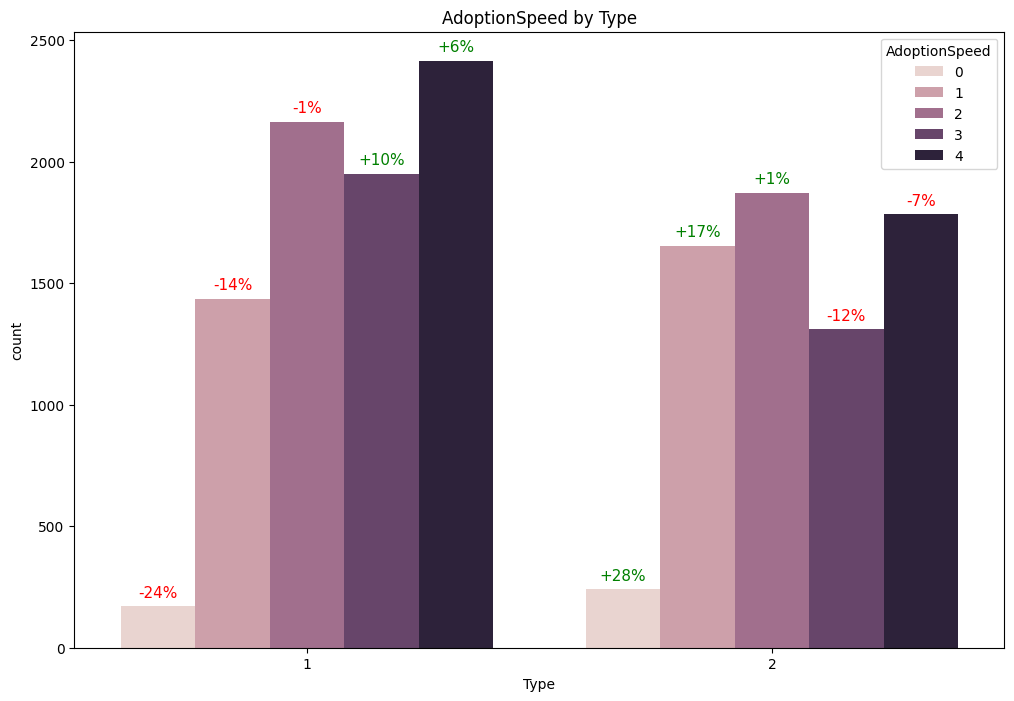

In [299]:
#VISUALIZACION ADOPTION SPEED POR TYPE: 
#POR QUE DA ERROR PERO SI MUESTRA EL GRAFICO Y RESULTADOS? 
prepare_plot_dict(dataset, 'Type', diccionario_maincount)
make_count_plot(dataset, x='Type', title='by Type')

En este grafico podemos observar que: 

-Gatos tienden a ser mas adoptados que los perros en las velocidades de adopcion mas rapidas. (Bajo adoptionspeed)

-Los perros tienden a ser mas adoptados que los gatos luego de haber pasado mucho tiempo de espera en adopcion. 

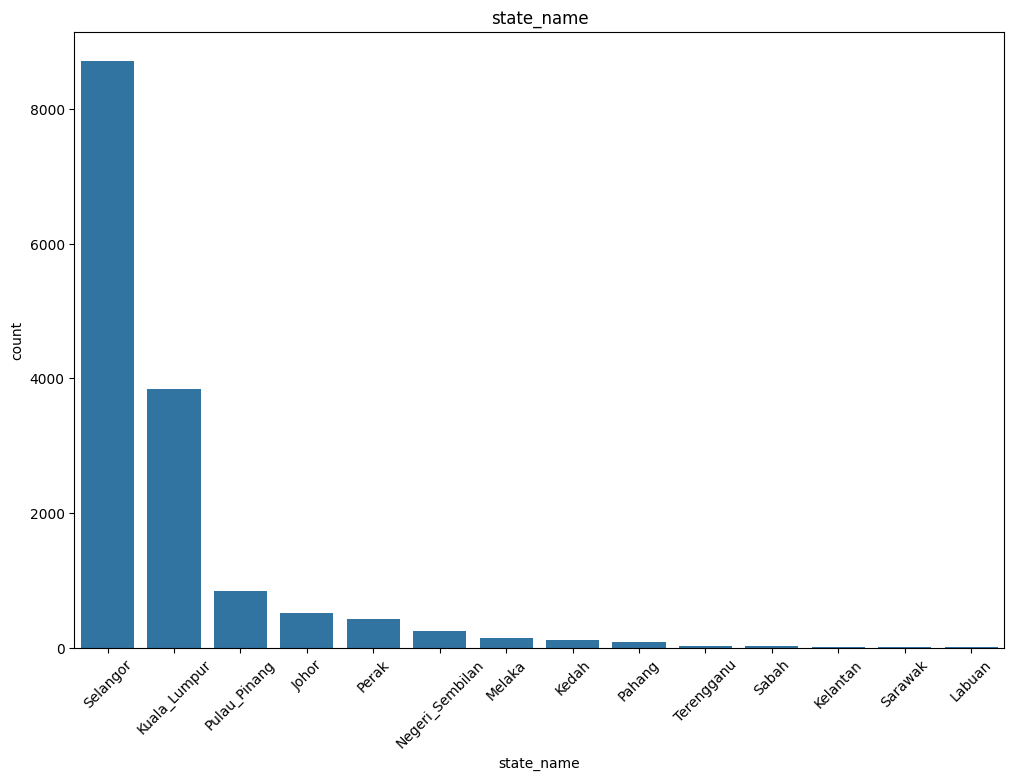

In [300]:
#ANALISIS STATE: 

states_dict = {k: v for k, v in zip(states['StateID'], states['StateName'])}
dataset['state_name'] = dataset['State'].apply(lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')

orden_state = dataset['state_name'].value_counts().index #Frecuencia de las combinaciones de colores ordenados de forma descendente. 

sns.countplot(data=dataset, x='state_name', order=orden_state)
plt.title('state_name')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x si es necesario
plt.show()

La mayoria de las publicaciones estan en Selangor & Kuala_Lumpur. 

In [301]:
data = []
for a in range(5):
    df = dataset.loc[dataset['AdoptionSpeed'] == a]

    data.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index,
        y = df['Age'].value_counts().sort_index().values,
        name = str(a)
    ))
    
layout = go.Layout(dict(title = "AdoptionSpeed trends by Age",
                  xaxis = dict(title = 'Age (months)'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=data, layout=layout), filename='basic-line')

-Las mas jovenes son las que mas rapido se adoptan.

-Los picos en las edades siguen un patron: 2, 12, 24, 36, 48, 60 (puede ser porque se suele redondear a la hora de determinar la edad de la mascota)

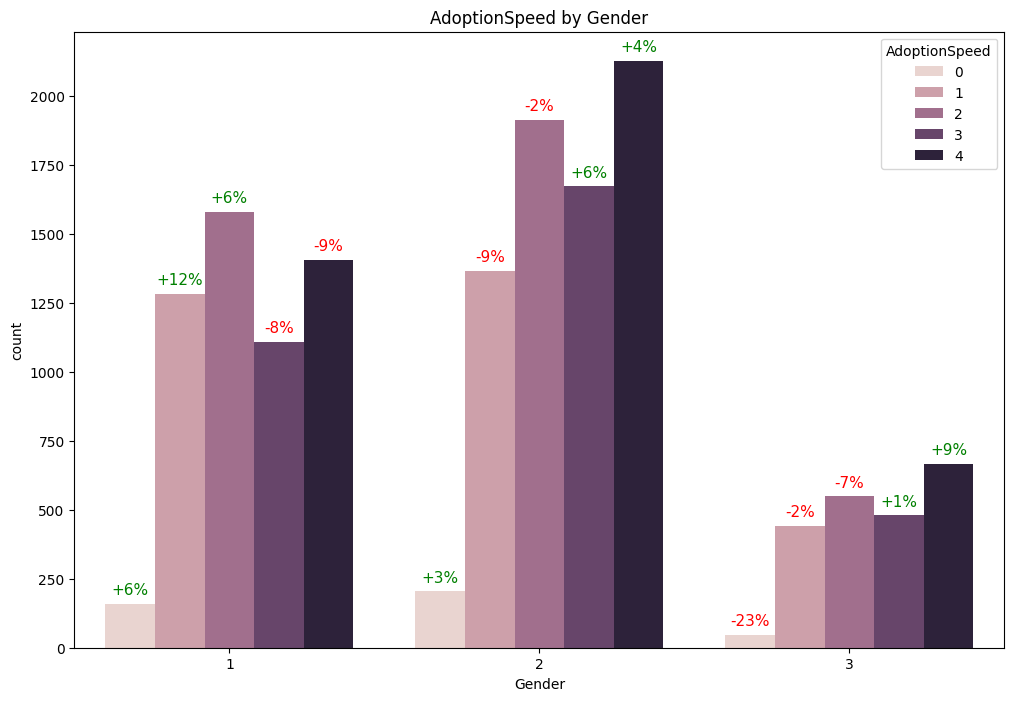

In [302]:
#ANALISIS GENERO: 
#1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets
make_count_plot(dataset, x='Gender', title= "by Gender")

Las tasas de adopcion son mas grandes para machos que para hembras; En el caso de no tener informacion disponible (gender=3) se puede ver una clara caida en la adopcion. 

Text(0.5, 1.0, 'AdoptionSpeed and Health')

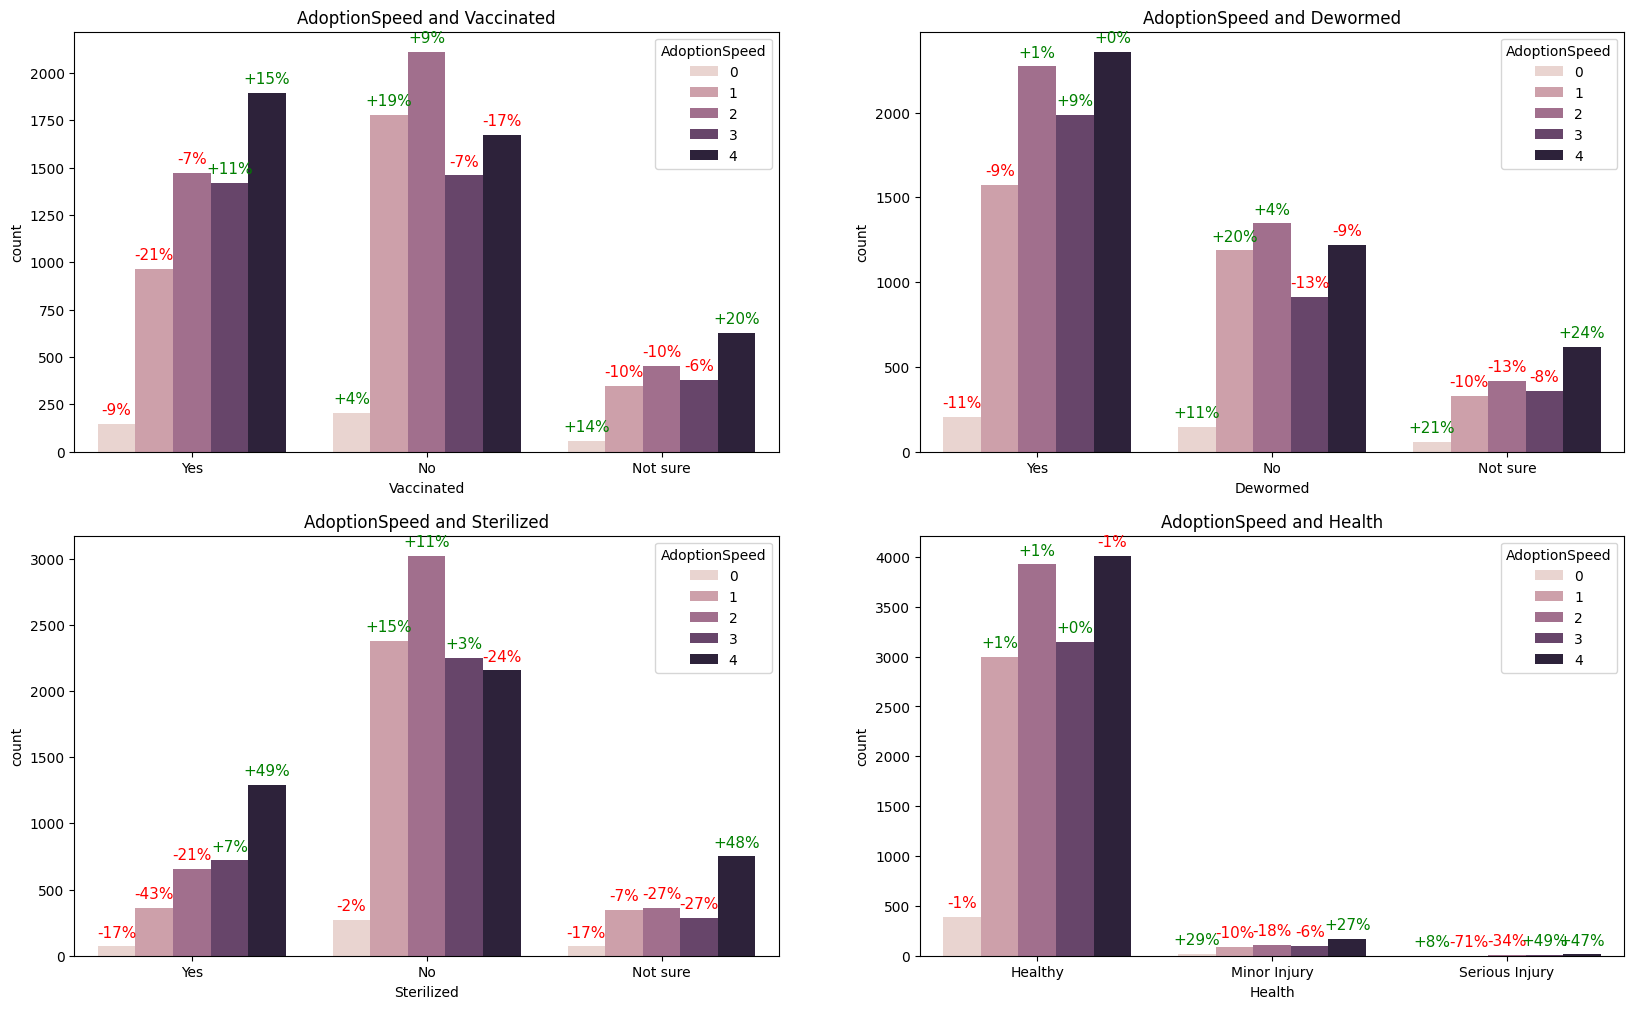

In [303]:
#ANALISIS SALUD

plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
make_count_plot(df=dataset, x='Vaccinated', title='Vaccinated')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure'])
plt.title('AdoptionSpeed and Vaccinated')

plt.subplot(2, 2, 2)
make_count_plot(df=dataset, x='Dewormed', title='Dewormed')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure'])
plt.title('AdoptionSpeed and Dewormed')

plt.subplot(2, 2, 3)
make_count_plot(df=dataset, x='Sterilized', title='Sterilized')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure'])
plt.title('AdoptionSpeed and Sterilized')

plt.subplot(2, 2, 4)
make_count_plot(df=dataset, x='Health', title='Health')
plt.xticks([0, 1, 2], ['Healthy', 'Minor Injury', 'Serious Injury'])
plt.title('AdoptionSpeed and Health')

En todas las causisticas de SALUD, se puede ver que el hecho de NO tener informacion disponible reduce mucho las chances de ser adoptado. Podria ser interesante una nueva feature en base a esta informacion.

## 4. Pre Procesamiento de datos

In [304]:
#ANALISIS NAME: 

# Contar NaN o Nulls en la columna 'Name'
nan_null_count = dataset['Name'].isna().sum()

# Contar registros vacíos en la columna 'Name'
empty_string_count = (dataset['Name'] == '').sum()

# Sumar ambos conteos para obtener el total de registros Nan/Nulls/Vacíos
total_nan_null_empty = nan_null_count + empty_string_count

print(f"Total NaN/Nulls: {nan_null_count}")
print(f"Total registros vacíos: {empty_string_count}")
print(f"Total NaN/Nulls/Vacíos: {total_nan_null_empty}")

Total NaN/Nulls: 1265
Total registros vacíos: 0
Total NaN/Nulls/Vacíos: 1265


<Axes: xlabel='Has_name', ylabel='count'>

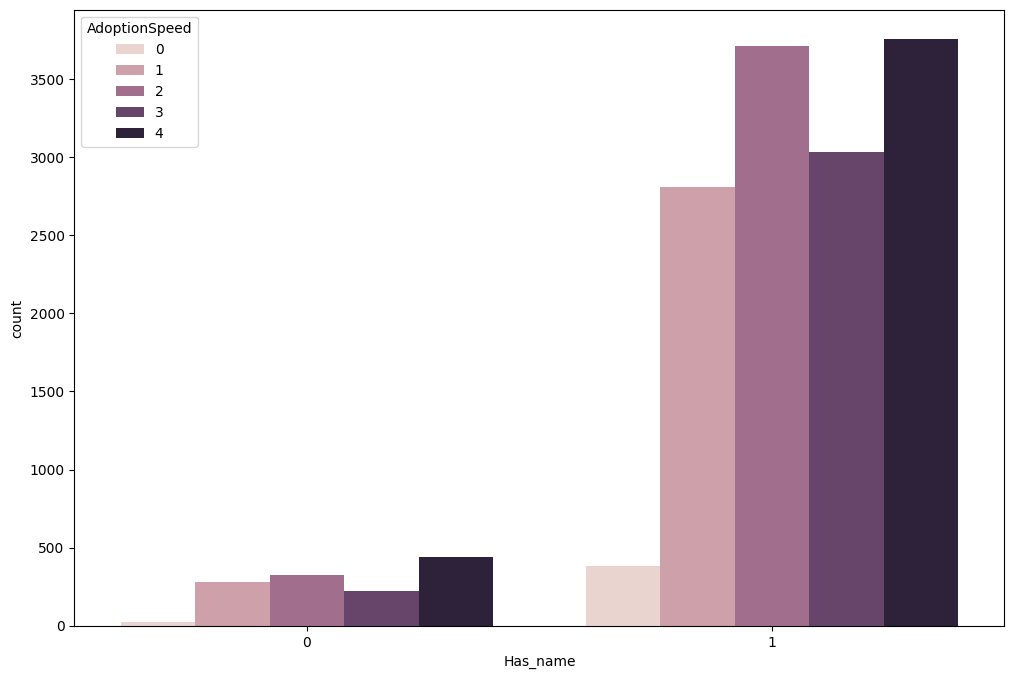

In [305]:
#reemplazo Na por Unnamed:
dataset['Name'] = dataset['Name'].fillna('Unnamed')
dataset['Name'] = dataset['Name'].replace('No Name Yet', 'Unnamed') 
dataset['Has_name'] = 1 #CREO UNA NUEVA COLUMNA QUE TENGA HAS_NAME = 1 ES DECIR, TODOS TIENEN NOMBRE
dataset.loc[dataset['Name'] == 'Unnamed', 'Has_name'] = 0 #LUEGO CAMBJO HAS_NAME A 0 PARA LOS QUE NO TIENEN NOMBRE. (LOC ENTRO A FILAS DONDE NAME = UNNAME, COLUMNA HAS NAME)
dataset.head()

test_dataset['Name'] = test_dataset['Name'].fillna('Unnamed')
test_dataset['Name'] = test_dataset['Name'].replace('No Name Yet', 'Unnamed')
test_dataset['Has_name'] = 1
test_dataset.loc[test_dataset['Name'] == 'Unnamed', 'Has_name'] = 0

sns.countplot(x='Has_name', data=dataset, hue='AdoptionSpeed')

In [306]:
#PROPORCION DE MASCOTAS SIN NOMBRE. 
print(f"Rate of unnamed pets in train data: {(dataset['Has_name'] == 0).sum() * 100 / dataset.shape[0]:.4f}%.")

Rate of unnamed pets in train data: 8.6174%.


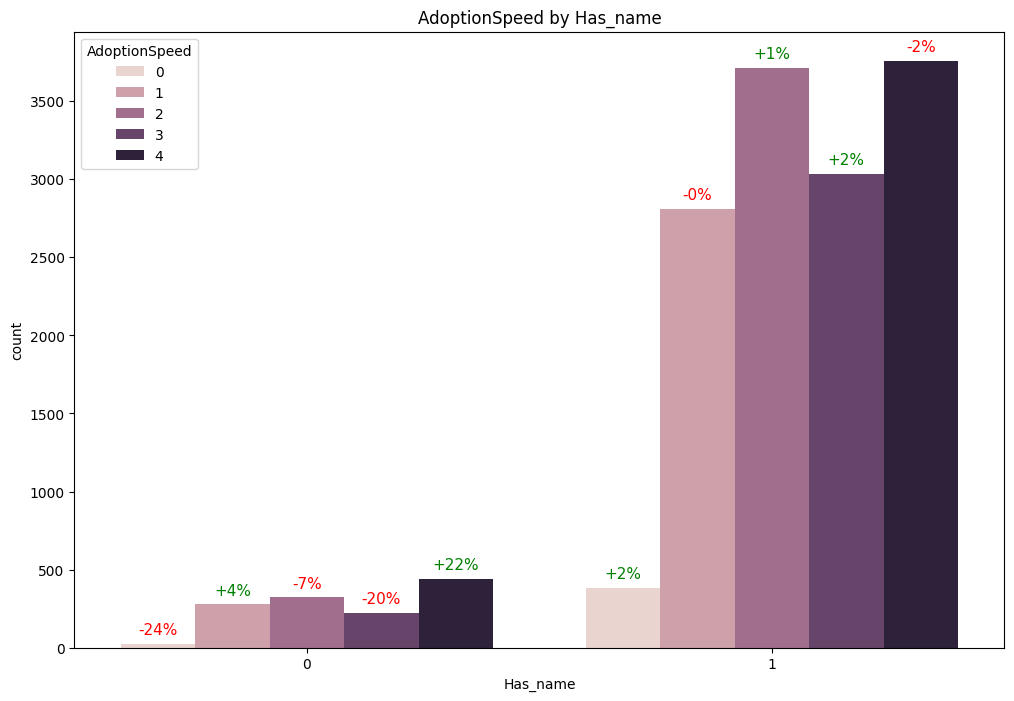

In [307]:
#VISUALIZAMOS LA ADOPTION SPEED RATE POR EL HECHO DE TENER O NO NOMBRE: 
make_count_plot(dataset, x='Has_name', title='by Has_name')

In [308]:
#EXISTEN "MALOS NOMBRES" O NOMBRES SIN SENTIDO? 
#CHECK NOMBRES CON MENOS DE 3 CARACTERES:
dataset[dataset['Name'].apply(lambda x: len(str(x))) < 3]['Name'].unique()

array(['H3', 'Z3', 'C', 'BB', 'QQ', 'Y1', 'H1', 'D9', 'Y4', 'Z4', 'DD',
       'M2', 'H6', 'D4', 'JJ', 'F1', 'W7', '1F', 'Q1', '6', 'CJ', '3F',
       'KD', 'G1', 'B3', 'Cc', 'F6', 'Mk', 'A5', 'GM', 'D5', 'EE', 'A4',
       'Q4', 'B', 'CC', 'Y7', 'W6', 'A3', 'A1', 'T1', 'W1', 'M4', 'P5',
       'H2', 'GG', 'Y6', 'Z', 'D7', 'B4', 'C2', 'M8', '3', 'G2', 'ML',
       'DJ', 'PP', '8', 'OJ', 'D', 'F2', 'MJ', 'W8', 'W4', 'C1', 'W2',
       'GR', 'B1', '5', 'Fa', 'Y5', 'M', 'F5', 'Y0', 'B2', 'Q6', 'G3',
       '..', 'S1', 'Qu', 'R9', 'W3', 'R7', 'Tj', 'P3', '7', '!', 'RC',
       'Z2', 'Q3', 'A2', 'QD', 'S', '-', 'R6', 'IV', 'Mo', 'W5', 'F8',
       'M6', 'M9', 'Py', 'Rt', 'F9', 'P6', 'AJ', 'Y3', 'D6', 'T2', 'F4',
       'T3', 'YY', '99', 'F7', 'W+', 'D2', '1', '#1', 'S4', '2', 'Am',
       'P', 'P4', 'R5', 'M3', 'R3', 'JD', 'BJ', 'L', 'KC', 'VV', 'M1',
       '!.', 'V6', 'P1', 'J', 'S3', 'A6', 'Cq', 'M5', 'B5', 'J1', 'O',
       '2F', 'Q2', 'Y2', 'AB', 'A', 'Jo', 'ET', 'A9', 'ST', 'Po', 'KK'

Partimos de la hipotesis de que el RescuerID puede ser un factor importante ya que algunos rescatistas podrian ser mas proactivos que otros. 

In [309]:
# Vemos si en el dataset de test hay rescatistas de train o son todos nuevos
train_rescuers = dataset['RescuerID'].unique()
test_rescuers = test_dataset['RescuerID'].unique()
print(f"Rescatistas en test que no estan en train: {len(set(test_rescuers) - set(train_rescuers))}")
print(f"Rescatistas que estan en train y en test: {len(set(test_rescuers) & set(train_rescuers))}")

Rescatistas en test que no estan en train: 1518
Rescatistas que estan en train y en test: 0


No usamos RescuerID porque no hay ningun Rescatista de train que se repita en test.

El dataset preprocesado en DescriptionFeaturesPipeline, tiene una nueva columna Language que es el lenguaje de la description, se transforma a categorica para que pueda ser procesada por LGM

In [310]:
dataset["Language"] = pd.Categorical(dataset["Language"])
test_dataset["Language"] = pd.Categorical(test_dataset["Language"], categories=dataset["Language"].cat.categories)

In [311]:
# pasamos las variables categoricas a pd.Categoricas para que las procese mejor lgm
dataset["Breed1"] = pd.Categorical(dataset["Breed1"])
dataset["Color1"] = pd.Categorical(dataset["Color1"])
dataset["Color2"] = pd.Categorical(dataset["Color2"])
dataset["Color3"] = pd.Categorical(dataset["Color3"])
dataset["Gender"] = pd.Categorical(dataset["Gender"])
dataset["MaturitySize"] = pd.Categorical(dataset["MaturitySize"])
dataset["FurLength"] = pd.Categorical(dataset["FurLength"])
dataset["Vaccinated"] = pd.Categorical(dataset["Vaccinated"])
dataset["Dewormed"] = pd.Categorical(dataset["Dewormed"])
dataset["Sterilized"] = pd.Categorical(dataset["Sterilized"])
dataset["Type"] = pd.Categorical(dataset["Type"])
dataset["Health"] = pd.Categorical(dataset["Health"])
dataset["State"] = pd.Categorical(dataset["State"])


test_dataset["Breed1"] = pd.Categorical(test_dataset["Breed1"])
test_dataset["Color1"] = pd.Categorical(test_dataset["Color1"])
test_dataset["Color2"] = pd.Categorical(test_dataset["Color2"])
test_dataset["Color3"] = pd.Categorical(test_dataset["Color3"])
test_dataset["Gender"] = pd.Categorical(test_dataset["Gender"])
test_dataset["MaturitySize"] = pd.Categorical(test_dataset["MaturitySize"])
test_dataset["FurLength"] = pd.Categorical(test_dataset["FurLength"])
test_dataset["Vaccinated"] = pd.Categorical(test_dataset["Vaccinated"])
test_dataset["Dewormed"] = pd.Categorical(test_dataset["Dewormed"])
test_dataset["Sterilized"] = pd.Categorical(test_dataset["Sterilized"])
test_dataset["Type"] = pd.Categorical(test_dataset["Type"])
test_dataset["Health"] = pd.Categorical(test_dataset["Health"])
test_dataset["State"] = pd.Categorical(test_dataset["State"])

## 5. Feature Engeneering

### Creamos features manuales derivadas de las features originales

In [312]:
def bad_name_feature(df):
    """
    Como hay nombres que son un código, creamos una feature que indique eso
    """
    df["bad_name"] = 0
    df.loc[df['Name'].apply(lambda x: len(str(x)) < 3), 'bad_name'] = 1
    return df


def desc_length_feature(df):
    """
    Creamos una feature que indique la longitud de la descripción
    """
    df['Description'] = df['Description'].fillna('')
    df['desc_length'] = df['Description'].apply(lambda x: len(x))
    return df

def desc_words_feature(df):
    """
    Creamos una feature que indique la cantidad de palabras en la descripción
    """
    df['desc_words'] = df['Description'].apply(lambda x: len(x.split()))
    return df

def Pure_breed_feature(df):
    """
    Creamos una feature que indique si la mascota es de raza pura
    """
    df['Pure_breed'] = 0
    df.loc[df['Breed2'] == 0, 'Pure_breed'] = 1
    return df

def num_colores_feature(df):
    """
    Creamos una feature que indique la cantidad de colores de la mascota
    """
    df['num_colores'] = df[['Color1', 'Color2', 'Color3']].apply(lambda x: sum(x != 0), axis=1)
    return df

def Free_feature(df):
    """
    Creamos una feature que indique si la mascota es gratuita
    """
    df['Free'] = df['Fee'].apply(lambda x: 1 if x == 0 else 0)
    return df

def health_combo_feature(df, df_train=None):
    """
    Creamos una feature que indique la combinación de salud de la mascota
    """
    df['health_combo'] = df.apply(lambda x: str(x['Vaccinated']) + str(x['Dewormed']) + str(x['Sterilized']) + str(x['Health']), axis=1)
    
    if df_train is not None:
        df["health_combo"] = pd.Categorical(df["health_combo"], categories=df_train["health_combo"].cat.categories)
    else:
        df["health_combo"] = pd.Categorical(df["health_combo"])
    return df

def color_combo_feature(df, df_train=None):
    """
    Creamos una feature que indique la combinación de colores de la mascota
    """
    df['color_combo'] = df.apply(lambda x: str(x['Color1']) + str(x['Color2']) + str(x['Color3']), axis=1)
    if df_train is not None:
        df["color_combo"] = pd.Categorical(df["color_combo"], categories=df_train["color_combo"].cat.categories)
    else:
        df["color_combo"] = pd.Categorical(df["color_combo"])
    return df

def color_type_feature(df):
    """
    Creamos una feature que indique si la mascota es de color puro o mezcla
    1 = color puro
    0 = mezcla
    """
    df['color_type'] = df[['Color1', 'Color2', 'Color3']].apply(lambda x: 1 if sum(x != 0) == 1 else 0, axis=1)
    return df

def quantity_bucket_feature(df):
    """
    Creamos una feature que indique el bucket de cantidad de mascotas
    """
    def clasificar_quantity(quantity):
        if quantity == 1:
            return 1
        elif 1 < quantity <= 3:
            return 2
        else:
            return 3
    df['quantity_bucket'] = df['Quantity'].apply(clasificar_quantity)
    return df

def main_states_feature(df):
    """
    Creamos una feature que indique si la mascota se encuentra en los estados principales
    (Selangor & Kuala_Lumpur)
    """
    df['main_states'] = df['State'].apply(lambda x: 1 if x in (41326,41401) else 0)
    return df

def has_video_feature(df):
    """
    Creamos una feature que indique si la mascota tiene video
    """
    df['has_video'] = df['VideoAmt'].apply(lambda x: 1 if x > 0 else 0)
    return df

def photos_bucket_feature(df):
    """
    Nueva variable que diferencie publicaciones por bucket de fotos
    """
    def clasificar_quantity_fotos(PhotoAmt):
        if PhotoAmt == 1:
            return 1
        elif 1 < PhotoAmt <= 5:
            return 2
        elif 5 < PhotoAmt <= 10:
            return 3    
        else:
            return 4
    df['photos_bucket'] = df['PhotoAmt'].apply(clasificar_quantity_fotos)
    return df

def fee_bucket_feature(df):
    df['fee_bucket'] = df['Fee'].apply(lambda x: 1 if x == 0 else 2 if x <= 100 else 3)
    return df

def age_group_feature(df):
    """
    Creamos una feature que indique el grupo de edad de la mascota
    """
    def classify_age(age):
        if age < 12:
            return 1 #joven
        elif 12 <= age <= 36:
            return  2 #mediana edad
        else:
            return 3 #adulto

    df['age_group']=df['Age'].apply(classify_age)
    return df


manual_features = [
    "bad_name", 
    "desc_length", 
    "desc_words", 
    "Pure_breed", 
    "num_colores", 
    "Free",
    "health_combo", 
    "color_combo", 
    "color_type", 
    "quantity_bucket", 
    "main_states", 
    "has_video", 
    "photos_bucket", 
    "fee_bucket",
    "age_group",
    ]

In [313]:
# calculo todas las features en el dataset de test y entrenamiento
for feature in manual_features:
    feature_func = globals()[feature + "_feature"]
    dataset = feature_func(dataset)
    if 'df_train' in feature_func.__code__.co_varnames:
        test_dataset = feature_func(test_dataset, dataset)
    else:
        test_dataset = globals()[feature + "_feature"](test_dataset)

#### Analisis de las features manuales

Text(0.5, 1.0, 'Distribution of description_length')

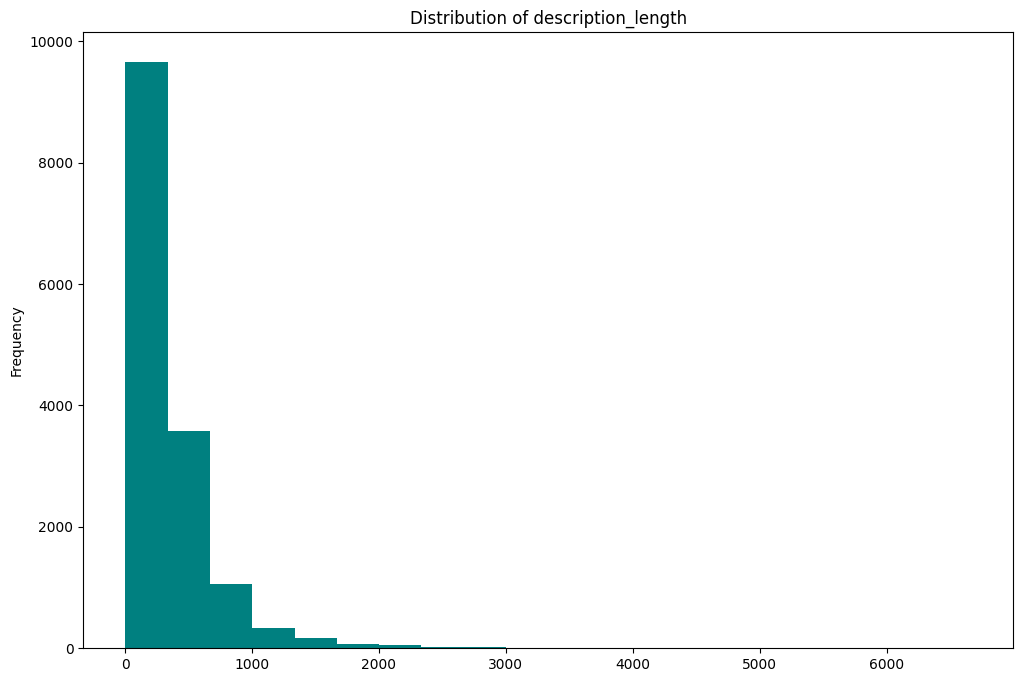

In [314]:
#ANALISIS DESCRIPCION: 
dataset['desc_length'].plot(kind='hist', bins=20, color='teal') 
plt.title('Distribution of description_length')

Text(0.5, 1.0, 'AdoptionSpeed by Type and count of words in description')

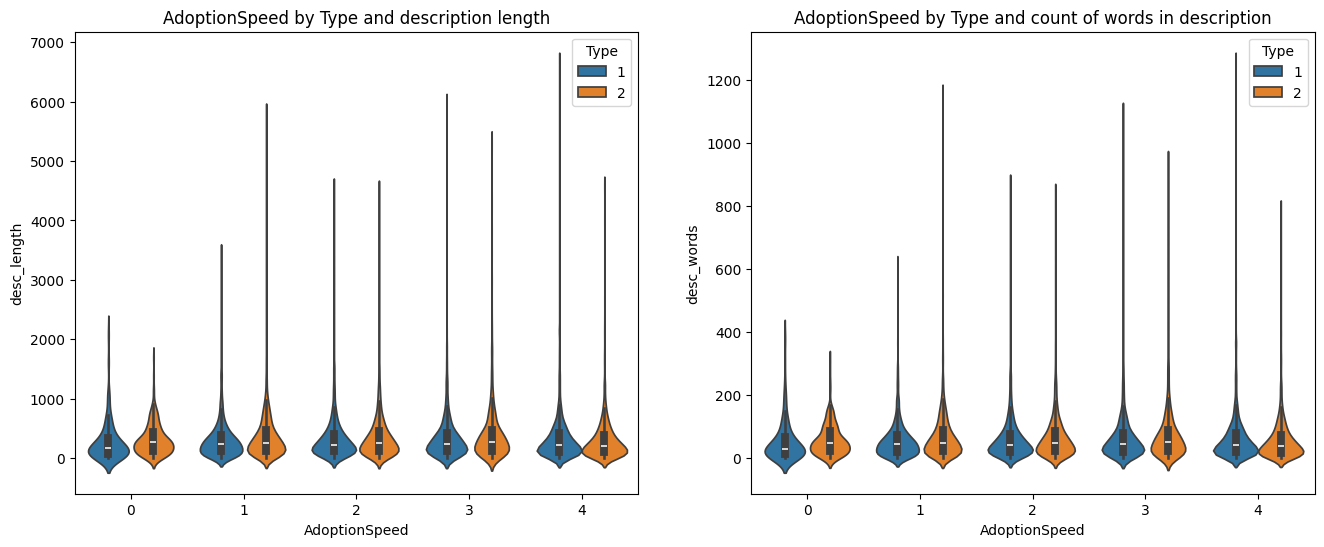

In [315]:
#COUNT PLOT DE DESCRIPTION LENGTH POR ADOPTION SPEED: ARMAR BUCKETS O VER PROMEDIOS. 
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
sns.violinplot(x="AdoptionSpeed", y="desc_length", hue="Type", data=dataset)
plt.title('AdoptionSpeed by Type and description length')

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="desc_words", hue="Type", data=dataset)
plt.title('AdoptionSpeed by Type and count of words in description')

Animales con descripciones mas cortas son adoptados mas rapido. 

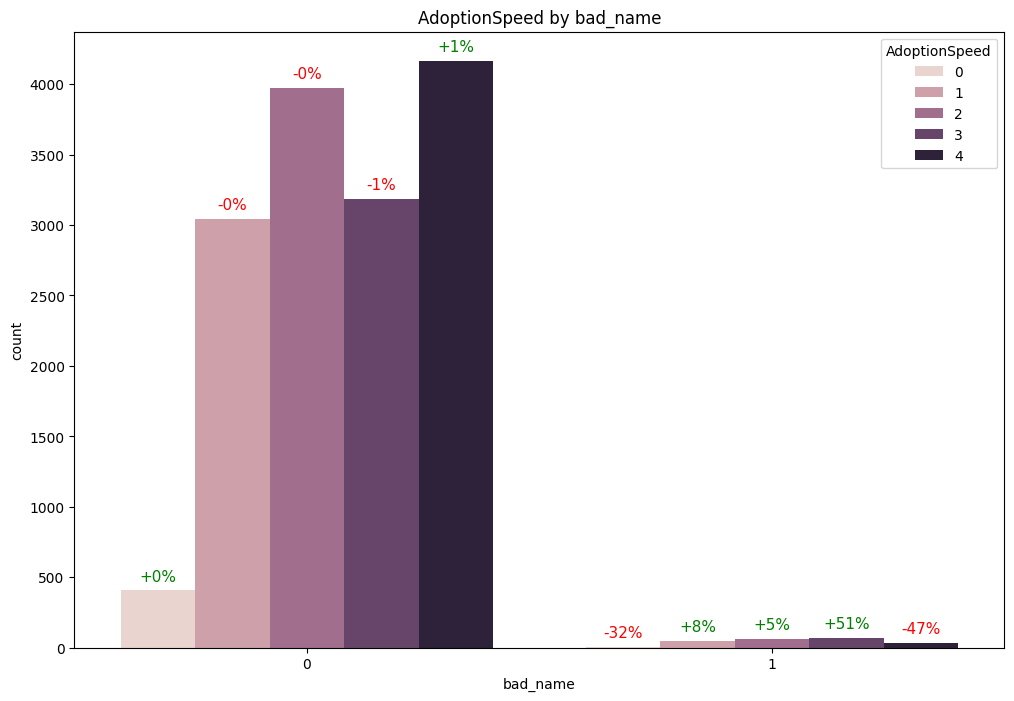

In [316]:
#VISUALIZAMOS LA ADOPTION SPEED RATE & BAD NAME
make_count_plot(dataset, x='bad_name', title='by bad_name')

Se puede apreciar que hay pocos casos de mascotas con nombres extraños (-bad names-); En el caso de adoption speed 0, muestra un -32% en la tasa de adoption & -47% en la de adopcion mas tardia. 
Los nombres los deberiamos borrar del set de datos para entrenar ya que son unicos. Mejor dejar feature que indique si tiene o no nombre/bad name feature.

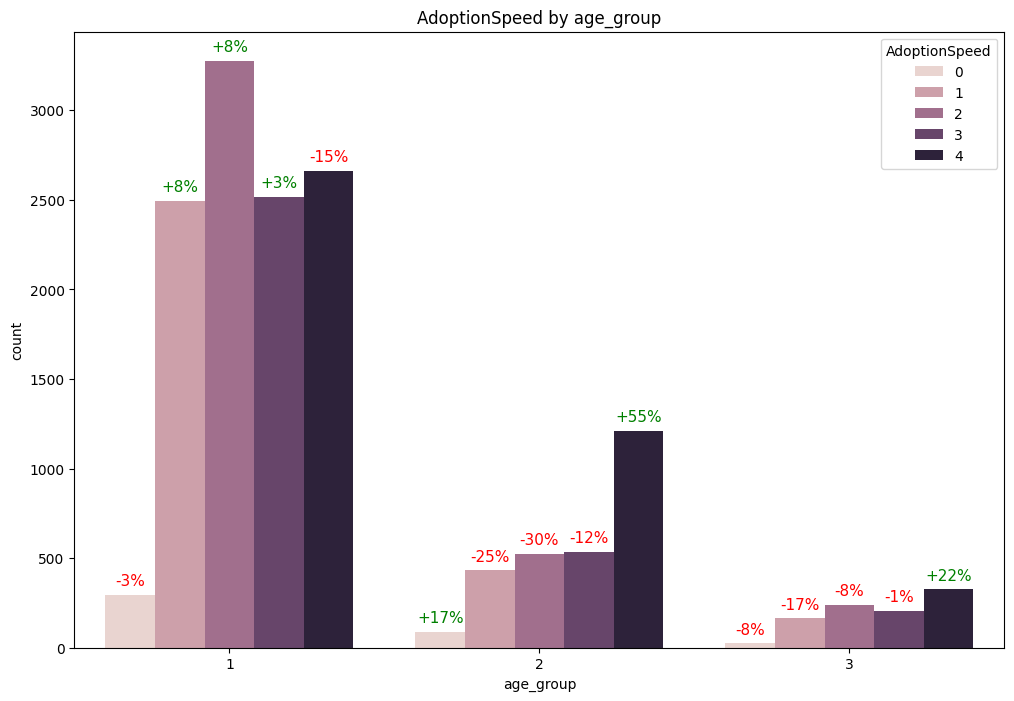

In [317]:
#VISUALIZO ADOPTION SPEED RATE POR GRUPO DE EDAD:
make_count_plot(dataset, x='age_group', title='by age_group')

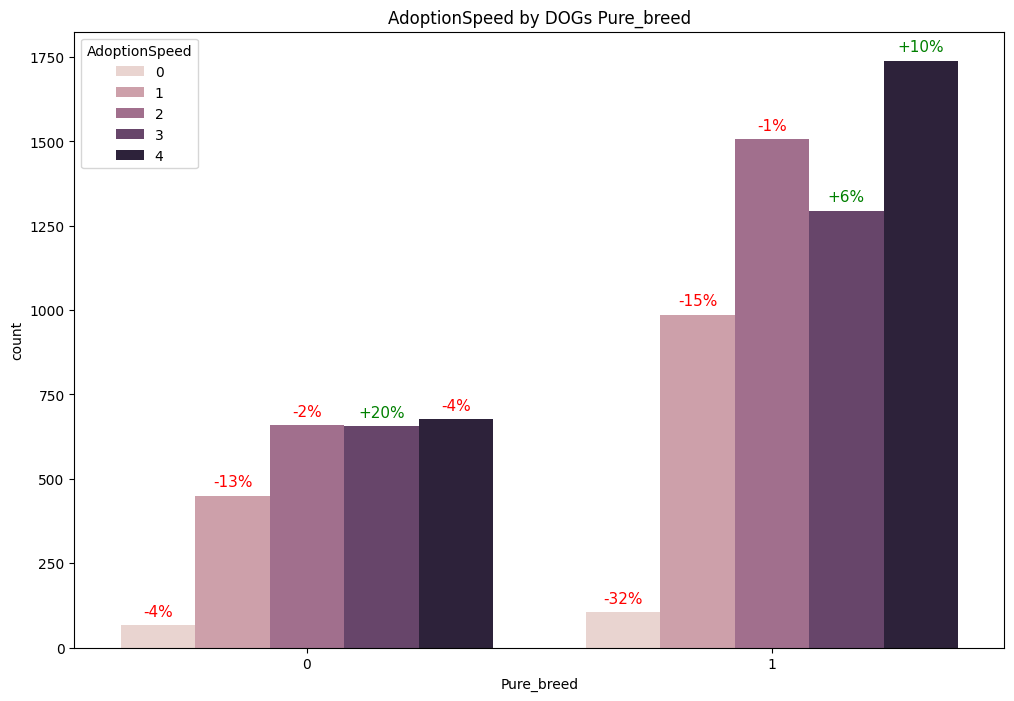

In [318]:
filter_df_dogs = dataset[dataset['Type'] == 1]
filter_df_cats = dataset[dataset['Type'] == 2]

make_count_plot(filter_df_dogs, x='Pure_breed', title='by DOGs Pure_breed') 

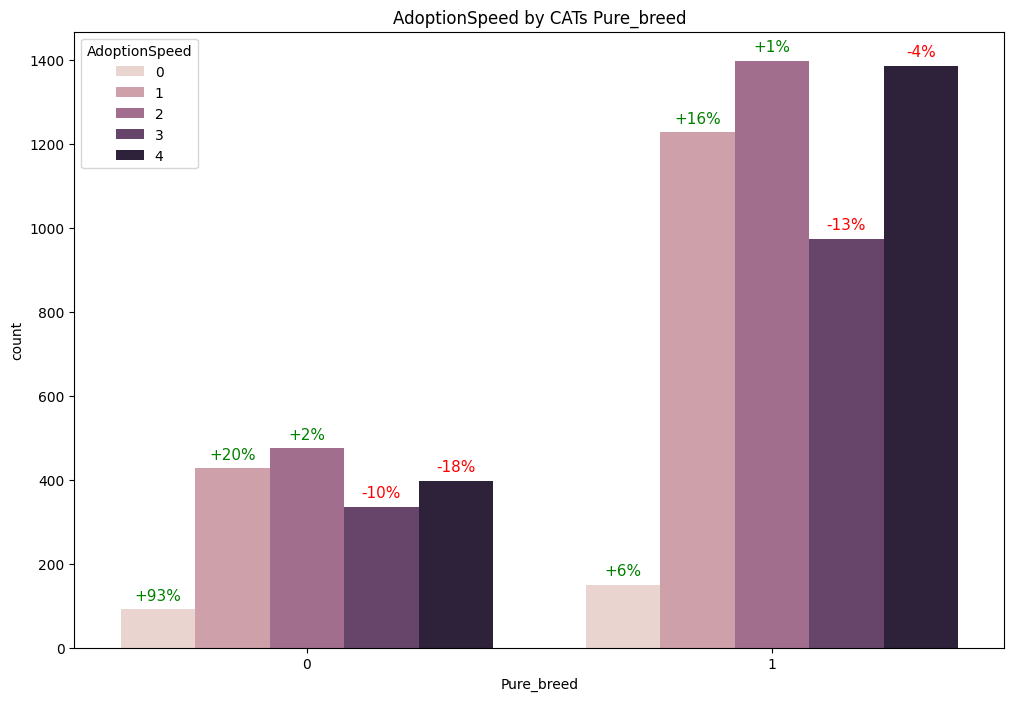

In [319]:
make_count_plot(filter_df_cats, x='Pure_breed', title='by CATs Pure_breed') 

Los animales que no son de raza pura son adoptados mas rapido. Se acentua mas en el caso de los gatos. 

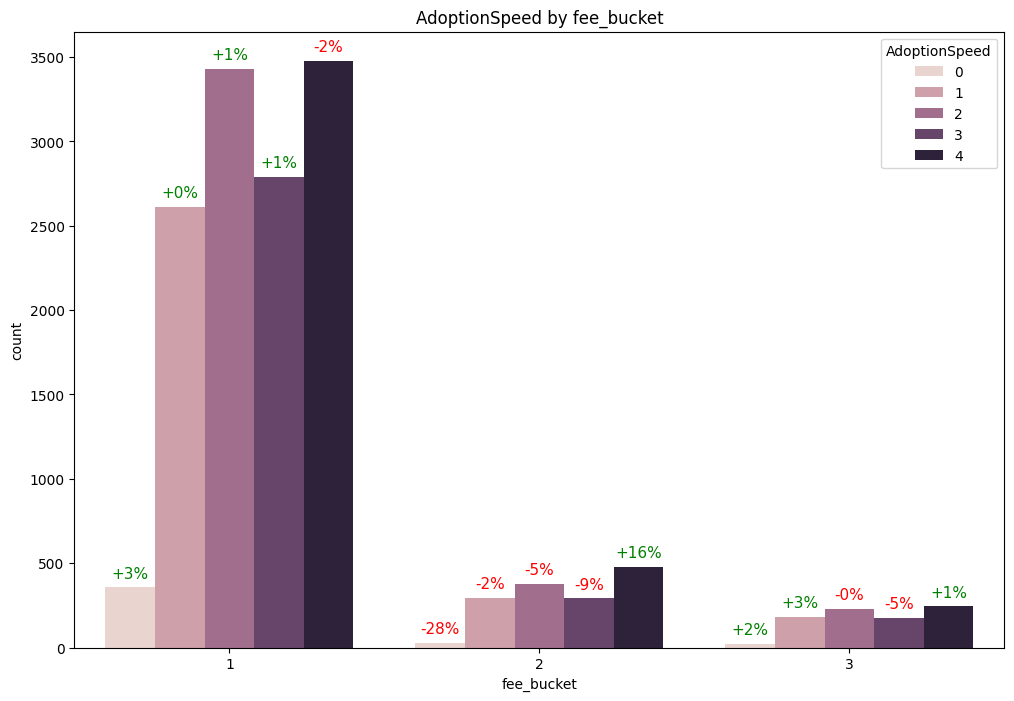

In [320]:
#GRAFICO FEE BUCKET & ADOPTION SPEED: 
make_count_plot(dataset, x='fee_bucket', title='by fee_bucket')

La mayoria de las mascotas no tienen un fee para ser adoptadas. 
Para diferenciar tomamos como punto de corte FEE = 100 USD. 
Vemos que: 
El grupo 2 (mayor a 0 & menos de 100 USD): Tienen menos chances de ser adoptados en cada clase de adoption speed
El grupo 3 (mayor a 100 USD) Tiene mejores chances vs el grupo 2. Quiza el FEE este asociado a otras caracteristicas: Salud del animal, adiestramiento, raza, ciudad. Pareceria haber un diferencial vs el grupo 2. 

### Features utilizando el analisis de sentimiento

Utilizamos el los json del proyecto con el analisis de sentimiento de las descripciones para crear nuevas features

In [321]:
def insert_sentiment_features(df, path):
    """
    Inserta las features de sentimientos en el dataframe
    """
    sentiment_files = os.listdir(path)
    scores = {}
    for file in sentiment_files:
        file_path = os.path.join(path, file)
        if not file.endswith('.json'):
            continue
        with open(file_path, 'r') as f:
            sentiment = json.load(f)
            pet_id = file.split('.')[0]
            scores[pet_id] = {
                "sentiment_score": sentiment['documentSentiment']['score'],
                "sentiment_magnitude": sentiment['documentSentiment']['magnitude']
            }
    sentiment_df = pd.DataFrame.from_dict(scores, orient='index')
    sentiment_df.reset_index(inplace=True)
    sentiment_df.columns = ['PetID', 'sentiment_score', 'sentiment_magnitude']
    # merge sentiment features
    df = pd.merge(df, sentiment_df, on='PetID', how='left')
    return df

def sentimiento(df):
    def clasificar_sentimiento(sentiment_score):
        if sentiment_score > 0.5:
            return 1
        elif sentiment_score < -0.5:
            return -1
        else:
            return 0
    df['sentiment'] = df['sentiment_score'].apply(clasificar_sentimiento)
    return df

sentiment_features =["sentiment_score", "sentiment_magnitude", "sentiment"]

In [322]:
dataset = insert_sentiment_features(dataset, PATH_TO_SENTIMENT_TRAIN)
test_dataset = insert_sentiment_features(test_dataset, PATH_TO_SENTIMENT_TEST)
dataset = sentimiento(dataset)
test_dataset = sentimiento(test_dataset)

/home/fede/.venvs/labo2/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 551 rows containing missing values.


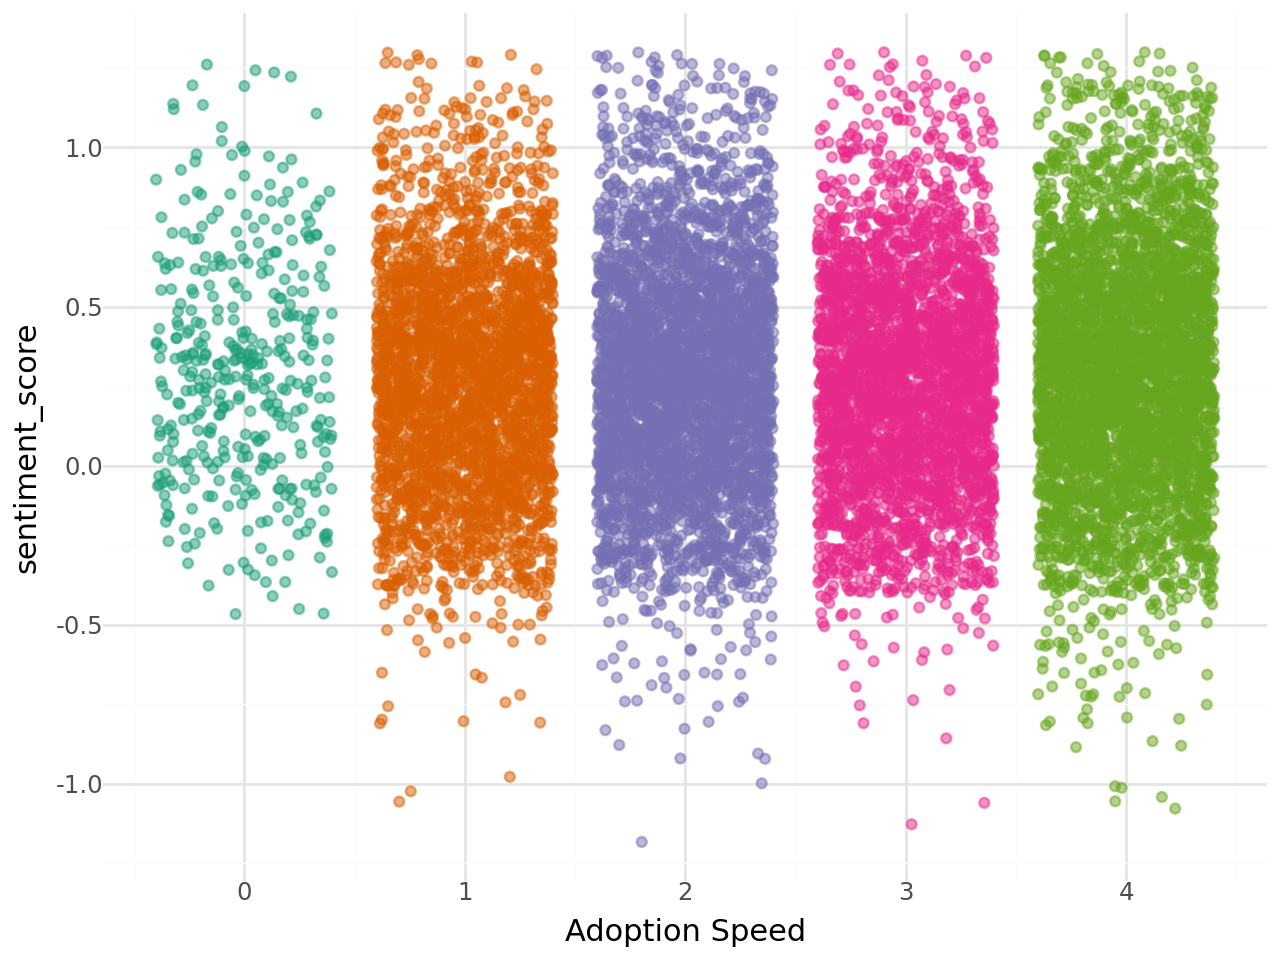

In [323]:
(ggplot(dataset, aes(x='AdoptionSpeed', y='sentiment_score', colour='factor(AdoptionSpeed)')) +
geom_jitter(alpha=0.5) +
scale_colour_brewer(palette="Dark2", type="qual") +
theme_minimal() +
labs(x="Adoption Speed", y="sentiment_score") +
theme(legend_position="none"))

In [324]:
fig = px.scatter(dataset, x='Breed1', y='sentiment_magnitude', color='AdoptionSpeed',
                 labels={'Breed1': 'Breed', 'sentiment_magnitude': 'sentiment_magnitude'},
                 title='Sentiment Magnitude by Breed1 for Different Adoption Speeds')

# Update layout to add selection capability
fig.update_layout(legend_title_text='Adoption Speed')

# Show the figure
fig.show()

El Jupyter ImageFeature.ipynb utiliza un zero-shot-clasificator para crear dos nuevas features en base a la imagen "HighQualityImage" y "WellFocusedImage"

In [325]:
pet_images_quality = pd.read_csv(PATH_PET_IMAGE_QUALITY_TRAIN)
dataset = dataset.merge(pet_images_quality, on='PetID', how='left')

pet_images_quality_test = pd.read_csv(PATH_PET_IMAGE_QUALITY_TEST)
test_dataset = test_dataset.merge(pet_images_quality_test, on='PetID', how='left')

features_images = ["HighQualityImage", "WellFocusedImage"]

El Jupyter ImagesFeaturesClip.ipynb utiliza un modelo que genera features en base a una imagen. Para esto se utilizo la primer imagen de cada mascota. 

In [326]:

clip_features_mean = ["clip_mean_"+str(i) for i in range(48)]
def add_clips_features(df, path):
    with open(path, "r") as f:
        clip_features = json.load(f)
    clip_features_df = pd.DataFrame(clip_features).T
    clip_features_features_names = [f'clip_{i}' for i in range(clip_features_df.shape[1])]
    clip_features_df.columns = clip_features_features_names
    # el indice en realidad es una columna PetId
    clip_features_df.reset_index(inplace=True)
    clip_features_df.rename(columns={'index':'PetID'}, inplace=True)

    # Como 768 features son muchas, reduzco la dimensionalidad a 48 calculando la media
    for i in range(48):
        clips_to_mean = [f'clip_{j}' for j in range(i*16, (i+1)*16)]
        clip_features_df[clip_features_mean[i]] = clip_features_df[clips_to_mean].mean(axis=1)
    # delete original features
    clip_features_df.drop(clip_features_features_names, axis=1, inplace=True)
    df = df.merge(clip_features_df, on='PetID', how='left')
    return df


In [327]:
dataset = add_clips_features(dataset, CLIP_FEATURES_TRAIN)
test_dataset = add_clips_features(test_dataset, CLIP_FEATURES_TEST)
dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,...,clip_mean_33,clip_mean_34,clip_mean_35,clip_mean_36,clip_mean_37,clip_mean_38,clip_mean_39,clip_mean_40,clip_mean_41,clip_mean_42,clip_mean_43,clip_mean_44,clip_mean_45,clip_mean_46,clip_mean_47
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,...,-0.081039,-0.042430,0.002275,-0.055048,-0.046137,-0.033951,-0.002770,-0.026052,-0.007847,0.002889,0.014563,-0.023772,-0.020490,-0.051442,-0.059243
1,2,Unnamed,1,265,0,1,1,2,0,2,2,3,3,3,1,...,-0.102949,-0.051559,-0.029091,-0.125065,-0.010613,-0.026650,-0.047285,-0.003179,-0.026675,-0.013732,-0.004998,-0.022682,0.040870,-0.011127,0.011112
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,...,-0.141652,-0.040403,-0.066333,0.015592,0.034930,-0.023217,-0.113306,-0.013069,0.016932,-0.032645,0.000530,-0.051696,-0.011268,-0.062509,0.022732
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,...,-0.142874,-0.095632,-0.066506,-0.049919,0.019752,0.007646,-0.050995,-0.021675,0.069602,-0.047197,0.032714,-0.025757,-0.011036,-0.073924,0.003733
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,...,-0.128990,-0.051718,-0.076471,-0.000623,0.079659,-0.013315,-0.038462,-0.039584,0.006617,-0.038545,-0.037867,0.009862,0.013154,-0.027284,-0.024250


images features

In [328]:
IMAGES_FEATURES_PATH = os.path.join(BASE_DIR, "train/train_reduced_features.csv")
train_features_images_df = pd.read_csv(IMAGES_FEATURES_PATH)
print(train_features_images_df.shape)
train_features_images_df.head()

(14652, 101)


,PetID,ImageFeature0,ImageFeature1,ImageFeature2,ImageFeature3,ImageFeature4,ImageFeature5,ImageFeature6,ImageFeature7,ImageFeature8,ImageFeature9,ImageFeature10,ImageFeature11,ImageFeature12,ImageFeature13,...,ImageFeature85,ImageFeature86,ImageFeature87,ImageFeature88,ImageFeature89,ImageFeature90,ImageFeature91,ImageFeature92,ImageFeature93,ImageFeature94,ImageFeature95,ImageFeature96,ImageFeature97,ImageFeature98,ImageFeature99
0,86e1089a3,-1.041373,-0.526173,-0.820465,-1.422826,0.597426,0.358381,0.988359,0.517311,-0.642276,-0.331582,-0.652784,-0.344214,-0.184584,0.300810,...,0.168619,-0.366852,0.141254,0.174610,0.493532,0.203698,0.783827,-0.309922,-0.542688,0.297543,0.553457,-0.389153,1.270178,0.585045,-0.036687
1,6296e909a,-1.251046,-0.729041,-0.801160,-1.237341,-0.759227,0.048316,0.331525,-0.032376,-0.517239,0.182963,0.198483,-0.543266,-0.971956,-0.664702,...,0.550246,0.619557,0.308748,0.570885,1.355541,0.479842,0.592619,-0.368777,-0.655971,0.368996,0.019820,-0.103006,0.748105,0.318310,-0.349845
2,3422e4906,-0.747330,0.141795,-0.487508,-0.821395,-0.248750,0.919899,0.697014,0.450488,-0.504837,0.016554,-1.106677,-0.829740,-1.047707,-1.012849,...,0.734847,0.188596,1.118085,0.299518,1.309872,-0.215547,0.347291,-0.035718,0.322190,1.510909,0.011976,-1.858213,0.745608,0.041612,0.332911
3,5842f1ff5,-0.438686,-0.351435,-0.695835,-0.494858,0.200288,0.716324,0.328232,0.174406,-0.775179,0.155832,-0.288838,-0.836385,-1.208319,-0.850541,...,0.318785,0.186501,1.056174,0.174933,0.822262,0.457497,1.111769,-0.050049,0.712504,1.046839,0.507781,-0.682051,0.793044,-0.109626,-0.004165
4,850a43f90,-0.241365,-0.625341,-0.423205,-0.689872,-0.592184,-0.386626,-0.044156,-0.880056,-1.788424,-0.710302,-0.545835,-0.010628,-0.366613,-0.436474,...,0.027159,0.200098,0.449829,-0.360055,0.796408,-0.233829,1.043556,0.011642,0.261902,0.303970,0.014687,-0.646285,1.584181,-0.384436,-0.382301


In [329]:
features_images_dinov2 = list(train_features_images_df.columns[1:])
features_images_dinov2

['ImageFeature0',
 'ImageFeature1',
 'ImageFeature2',
 'ImageFeature3',
 'ImageFeature4',
 'ImageFeature5',
 'ImageFeature6',
 'ImageFeature7',
 'ImageFeature8',
 'ImageFeature9',
 'ImageFeature10',
 'ImageFeature11',
 'ImageFeature12',
 'ImageFeature13',
 'ImageFeature14',
 'ImageFeature15',
 'ImageFeature16',
 'ImageFeature17',
 'ImageFeature18',
 'ImageFeature19',
 'ImageFeature20',
 'ImageFeature21',
 'ImageFeature22',
 'ImageFeature23',
 'ImageFeature24',
 'ImageFeature25',
 'ImageFeature26',
 'ImageFeature27',
 'ImageFeature28',
 'ImageFeature29',
 'ImageFeature30',
 'ImageFeature31',
 'ImageFeature32',
 'ImageFeature33',
 'ImageFeature34',
 'ImageFeature35',
 'ImageFeature36',
 'ImageFeature37',
 'ImageFeature38',
 'ImageFeature39',
 'ImageFeature40',
 'ImageFeature41',
 'ImageFeature42',
 'ImageFeature43',
 'ImageFeature44',
 'ImageFeature45',
 'ImageFeature46',
 'ImageFeature47',
 'ImageFeature48',
 'ImageFeature49',
 'ImageFeature50',
 'ImageFeature51',
 'ImageFeature52',
 'I

Genero features de la descripcion

In [330]:
dataset = dataset.merge(train_features_images_df, on='PetID', how='left')

In [331]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

n_components = 150
text_features = []


tfv = TfidfVectorizer(min_df=2,  max_features=None,
                        strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
                        ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True)
svd_ = TruncatedSVD(
    n_components=n_components, random_state=1337)
    
tfidf_col = tfv.fit_transform(dataset["Description"].values)





In [332]:
svd_col = svd_.fit_transform(tfidf_col)
svd_col.shape

(14993, 150)

In [333]:
description_features = ["svd_desc_{}".format(i) for i in range(n_components)]
desc_df = pd.DataFrame(svd_col, columns=description_features)
desc_df["PetID"] = dataset["PetID"].values
dataset = dataset.merge(desc_df, on="PetID", how="left")

In [334]:
dataset.shape

(14993, 357)

Utilizamos los metadatos del analisis de imagenes que está en el proyecto, para eso creamos 3 nuevas columnas color_red, color_blue y color_green que son los valores RGB del color principal de todas las imagenes para una mascota

In [335]:

def read_metadata(path):
    metadata_jsons = {} # dict the petid y list of jsons

    for metadata_file in os.listdir(path):
        with open(os.path.join(path, metadata_file), 'r') as f:

            image_name = metadata_file.split('.')[0]
            pet_id = image_name.split('-')[0]
            if pet_id not in metadata_jsons:
                metadata_jsons[pet_id] = []
            metadata_jsons[pet_id].append(json.load(f))
    return metadata_jsons

def obtain_main_color(metadata_jsons):
    main_colors = {}

    for pet_id, metadata in metadata_jsons.items():
        max_score = 0
        main_color = None
        for m in metadata:
            if 'imagePropertiesAnnotation' in m:
                for color in m['imagePropertiesAnnotation']['dominantColors']['colors']:
                    if color['score'] > max_score:
                        max_score = color['score']
                        main_color = [color['color']['red'], color['color']['green'], color['color']['blue']]
        main_colors[pet_id] = main_color
    return main_colors

def add_metadata_features(df, main_colors):
    main_colors_df = pd.DataFrame(main_colors).T
    main_colors_df.columns = ['main_color_red', 'main_color_green', 'main_color_blue']
    main_colors_df.reset_index(inplace=True)
    main_colors_df.rename(columns={'index':'PetID'}, inplace=True)
    df = pd.merge(df, main_colors_df, on='PetID', how='left')
    return df

metadata_features = ["main_color_red", "main_color_green", "main_color_blue"]

In [336]:
metadata_train = read_metadata(PATH_TO_METADATA_TRAIN)
main_colors_train = obtain_main_color(metadata_train)
dataset = add_metadata_features(dataset, main_colors_train)
dataset.shape

(14993, 360)

In [337]:
metadata_test = read_metadata(PATH_TO_METADATA_TEST)
main_colors_test = obtain_main_color(metadata_test)
test_dataset = add_metadata_features(test_dataset, main_colors_test)
test_dataset.shape

(3972, 108)

Creamos features con los textos del analisis de sentimiento

In [370]:
text_metadata_features = ["svd_text_metadata_{}".format(i) for i in range(30)]

def extract_metadata_text_features(df, path):
    metadata_paths = os.listdir(path)
    texts = {}
    for file in metadata_paths:
        file_path = os.path.join(path, file)
        if not file.endswith('.json'):
            continue
        with open(file_path, 'r') as f:
            metadata = json.load(f)
            pet_id = file.split('.')[0].split("-")[0]
            if not "labelAnnotations" in metadata:
                continue
            sentiment_text = [annotation["description"] for annotation in metadata["labelAnnotations"]]
            texts[pet_id] = " ".join(sentiment_text)
    print(len(texts.keys()))
    texts_df = pd.DataFrame.from_dict(texts, orient='index')
    print(texts_df.shape)
    n_components = 30

    tfv = TfidfVectorizer(min_df=2,  max_features=None,
                            strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
                            ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True)
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1337)
        
    tfidf_col = tfv.fit_transform(texts_df[0].values)
    svd_col = svd_.fit_transform(tfidf_col)
    text_df = pd.DataFrame(svd_col, columns=text_metadata_features)
    text_df["PetID"] = texts_df.index
    df = df.merge(text_df, on="PetID", how="left")
    return df

dataset = extract_metadata_text_features(dataset, PATH_TO_METADATA_TRAIN)
test_dataset = extract_metadata_text_features(test_dataset, PATH_TO_METADATA_TEST)
dataset[["PetID"] + text_metadata_features].head()

14652
(14652, 1)
3858
(3858, 1)


,PetID,svd_text_metadata_0,svd_text_metadata_1,svd_text_metadata_2,svd_text_metadata_3,svd_text_metadata_4,svd_text_metadata_5,svd_text_metadata_6,svd_text_metadata_7,svd_text_metadata_8,svd_text_metadata_9,svd_text_metadata_10,svd_text_metadata_11,svd_text_metadata_12,svd_text_metadata_13,...,svd_text_metadata_15,svd_text_metadata_16,svd_text_metadata_17,svd_text_metadata_18,svd_text_metadata_19,svd_text_metadata_20,svd_text_metadata_21,svd_text_metadata_22,svd_text_metadata_23,svd_text_metadata_24,svd_text_metadata_25,svd_text_metadata_26,svd_text_metadata_27,svd_text_metadata_28,svd_text_metadata_29
0,86e1089a3,0.385685,-0.112620,-0.016840,-0.103077,-0.033761,-0.049407,0.035589,0.046505,-0.101337,-0.029622,-0.037243,-0.104046,0.020305,0.061453,...,0.107504,0.063466,0.147633,-0.068732,0.079554,0.054354,0.013986,-0.034154,-0.065551,0.007736,0.108710,-0.047118,-0.062949,0.209175,0.026087
1,6296e909a,0.286692,0.010519,-0.057526,-0.086835,0.062155,-0.032262,0.023930,0.000500,-0.025594,0.054891,-0.068999,0.062619,-0.038667,0.257141,...,0.022805,-0.012654,-0.005496,0.074290,0.166780,0.026392,0.119932,-0.117681,-0.094301,-0.001196,0.133161,-0.035967,-0.026897,0.100384,-0.052230
2,3422e4906,0.104786,0.327841,0.008384,0.014617,0.012050,0.079231,-0.153264,0.292428,0.116756,-0.019382,-0.011087,-0.009741,0.017248,0.014143,...,0.000744,0.131069,-0.040517,0.059047,-0.024999,0.064484,-0.016554,0.004383,-0.021458,0.026761,0.012077,0.003332,0.008299,-0.000086,0.023891
3,5842f1ff5,0.161432,0.446731,-0.000216,0.003795,-0.002888,0.013881,0.020523,-0.068693,-0.053217,0.016248,0.024801,0.005832,-0.002110,-0.015448,...,-0.152748,0.030452,0.106775,0.063982,-0.004919,-0.079208,-0.020263,0.002740,-0.066049,0.115522,0.025816,-0.075976,-0.087138,-0.039099,-0.015206
4,850a43f90,0.058146,0.146281,-0.002414,-0.038882,0.021730,0.029049,-0.028439,-0.010053,-0.015750,-0.001048,-0.011142,-0.002493,-0.009822,-0.010072,...,-0.027175,0.003826,-0.019082,-0.028739,0.004176,0.011416,-0.009595,-0.004048,-0.000262,0.000550,-0.005709,-0.011250,0.005297,-0.006512,0.004827


Los dataset preprocesados por DescriptionFeaturesPipeline utilizan un LLM para analizar las descripciones y crear las siguientes features

In [338]:
llm_features = [
    'Is the pet described as friendly?',
    'Does the pet require special care?',
    'Is the pet currently with the owner?',
    'Is the pet good with other animals?', 
    "Is the pet's adoption urgent?",
    'Does the pet need a lot of space?',
    'Is the pet described as lovely or loveable?',
    'Is there a contact person mentioned?',
    'Must these pets be adopted as a group?',
    'Does the pet need medical care?', 
    'must always be kept indoors',
    "Language"
]

In [402]:
original_features = [
    "Type",
    'Age',
    'Breed1',
    'Breed2',
    'Gender',
    'Color1',
    'Color2',
    'Color3',
    'MaturitySize',
    'FurLength',
    'Vaccinated',
    'Dewormed',
    'Sterilized',
    'Health',
    'Quantity',
    'Fee',
    'State',
    'VideoAmt',
    'PhotoAmt',
    "Has_name"
]
features = ([] 
    + original_features
    + manual_features
    + sentiment_features
    + features_images
    + llm_features
    + metadata_features
    + clip_features_mean
    + features_images_dinov2
    + description_features
    + text_metadata_features
)
label = 'AdoptionSpeed'


## 6. Separa la base de Test y Train

In [403]:
train, test = train_test_split(dataset,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = dataset.AdoptionSpeed)

In [404]:
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

In [405]:
lgb_params = params = {
                        'objective': 'multiclass',
                        'num_class': len(y_train.unique()),
                        "verbosity": -1,
                        }


lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train,)


lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

KeyboardInterrupt: 

In [ ]:
y_pred = lgb_model.predict(X_test).argmax(axis=1)

cohen_kappa_score(y_test,y_pred, weights = 'quadratic')

0.35943640362553897

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

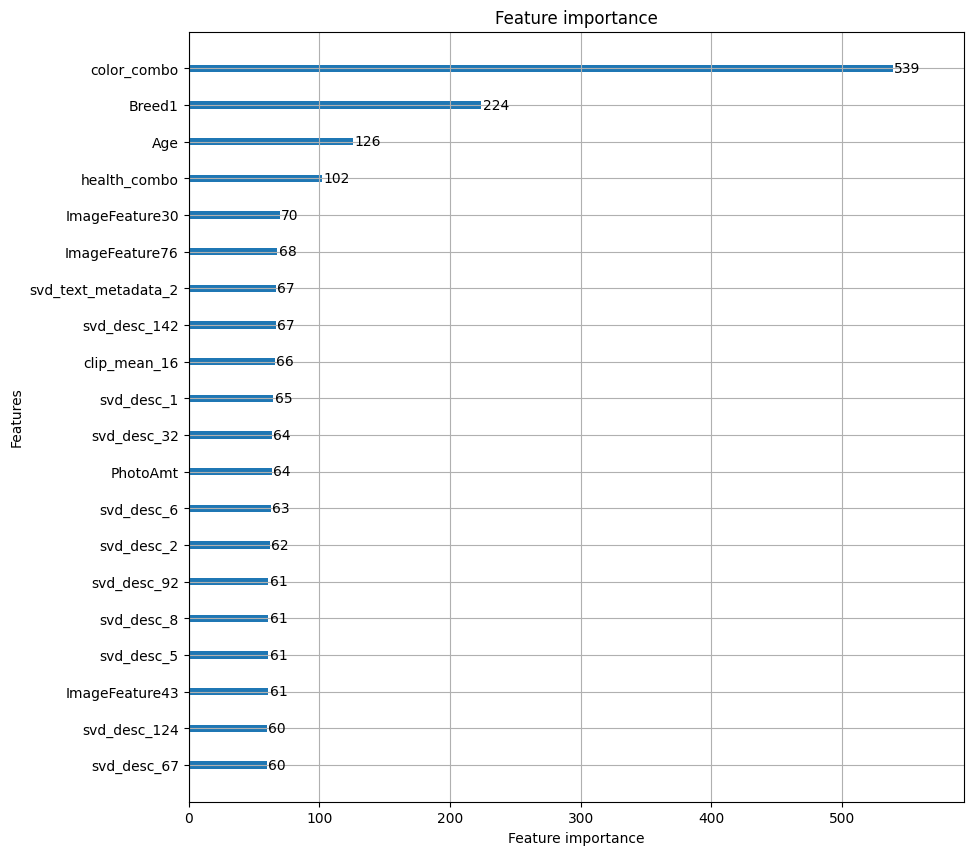

In [406]:
lgb.plot_importance(lgb_model, importance_type='auto', figsize=(10,10), max_num_features=20)

### 7. Para la parte de Train, armar un esquema de Cross Validation

In [410]:
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

def lgb_custom_metric_kappa(dy_pred, dy_true):

    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

def cv_es_lgb_objective(trial):

    lgb_params = {      
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 20.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 


    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))
    score_folds = 0
    n_splits = 5


    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                        label=y_train.iloc[if_index],
                                        free_raw_data=False)
        
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                        label=y_train.iloc[oof_index],
                                        free_raw_data=False)

        lgb_model = lgb.train(lgb_params,
                                lgb_if_dataset,
                                valid_sets=lgb_oof_dataset,
                                callbacks=[lgb.early_stopping(40, verbose=False)],
                                feval = lgb_custom_metric_kappa
                                )
        
        scores_ensemble = scores_ensemble + lgb_model.predict(X_test) #prediction!!!!
        
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                            lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1),weights = 'quadratic')/n_splits


    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    predicted_df = test.copy()
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    dump(predicted_df, predicted_filename)
    upload_artifact(trial, predicted_filename, artifact_store)    

    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    upload_artifact(trial, cm_filename, artifact_store)

    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    return(score_folds)

/tmp/ipykernel_15016/596608016.py:1: ExperimentalWarning: FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.


In [411]:

# usamos n_startup_trials de 28 porque optimizamos 7 variables (4*7)
n_startup_trials = 7*6
n_trials = 150
sampler = optuna.samplers.TPESampler(seed=SEED, n_startup_trials=n_startup_trials)

study = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="TP Final con imagenes dinov2 y clip +  features desc + text metadata",
                            load_if_exists = True,
                            sampler=sampler)

study.optimize(cv_es_lgb_objective, n_trials=(n_trials+n_startup_trials))

[I 2024-07-03 22:43:23,432] A new study created in RDB with name: TP Final con imagenes dinov2 y clip +  features desc + text metadata


In [356]:
# Reentrenamos el modelo con los mejores hiperparámetros y lo probamos en test
lgb_params =  {      
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_iterations': 9999,
                        'num_class': len(y_train.unique())} | study.best_params


X_train_, X_val = train_test_split(X_train, test_size=0.1, random_state=SEED, stratify=y_train)

y_train_ = y_train.loc[X_train_.index]
y_val = y_train.loc[X_val.index]

lgb_train_dataset = lgb.Dataset(data=X_train_,
                                label=y_train_,)
lgb_val_dataset = lgb.Dataset(data=X_val,
                                label=y_val,)


lgb_model = lgb.train(lgb_params,
                        lgb_train_dataset,
            
                        valid_sets=lgb_val_dataset,
                        callbacks=[lgb.early_stopping(808, verbose=False)],
                        feval = lgb_custom_metric_kappa
                        )

y_pred = lgb_model.predict(X_test).argmax(axis=1)
cohen_kappa_score(y_test, y_pred, weights='quadratic')

/home/fede/.venvs/labo2/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument


0.35424491399350233

El kappa empeoró luego de la optimizacion!

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

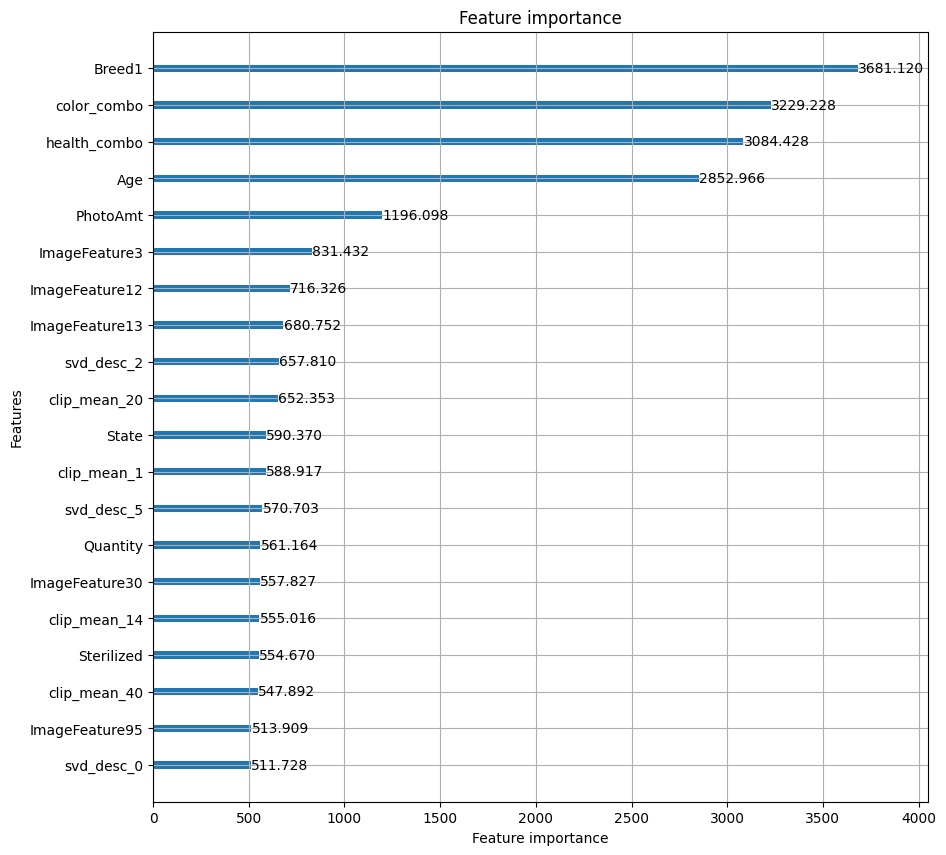

In [358]:
lgb.plot_importance(lgb_model, importance_type='gain', figsize=(10,10), max_num_features=20)

### 8. Prediccion para kaggle

In [62]:
# reentrenamos el modelo con los mejores parametros pero para todo el dataset

final_train, final_eval = train_test_split(dataset,
                                           test_size = TEST_SIZE,
                                           random_state = SEED,
                                           stratify = dataset.AdoptionSpeed)


lgb_final_train_dataset = lgb.Dataset(data=final_train[features],
                                        label=final_train[label])

lgb_final_eval_dataset = lgb.Dataset(data=final_eval[features],
                                        label=final_eval[label])

lgb_final_model = lgb.train(lgb_params,
                            lgb_final_train_dataset,
                            valid_sets=lgb_final_eval_dataset,
                            callbacks=[lgb.early_stopping(808, verbose=False)],
                            feval = lgb_custom_metric_kappa
                            )

# guardamos el modelo
model_filename = os.path.join(PATH_TO_MODELS, "lgb_final_model.joblib")

In [63]:
# predecimos sobre el dataset de test
test_dataset['AdoptionSpeed'] = lgb_final_model.predict(test_dataset[features]).argmax(axis=1)

In [64]:
# creamos submit.csv y lo guardamos en este directorio
submit_df = test_dataset[['PetID', 'AdoptionSpeed']]
submit_df.to_csv("submit.csv", index=False)

## 9. Valoración del modelo/conclusiones